# Gaussian process regression

In [35]:
### Importing Libraries and csv file

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, WhiteKernel as WK, Matern, RBF, DotProduct as Lin, RationalQuadratic as RQ, ExpSineSquared as Exp
np.random.seed(1)

#working_directory = os.getcwd()

#path = working_directory + '/house_dataset.csv'
dataset = pd.read_csv("/Users/ridsmbp/Library/CloudStorage/OneDrive-Personal/Riddhi Machine Learning/Datasets/Datasets/GPR Housing Dataset/house_dataset.csv")
dataset.head()


id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7      1180.0              0   
1      7242     2.0           0     0  ...      7      2170.0            400   
2     10000     1.0           0     0  ...      6       770.0              0   
3      5000     1.0           0     0  ...      7      1050.0            910   
4      8080     1.0           0     0  ...      8      1680.0              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

In [24]:
# Getting the number of missing values in each column
num_missing = dataset.isna().sum()
# Excluding columns that contains 0 missing values
num_missing = num_missing[num_missing > 0]
# Getting the percentages of missing values
percent_missing = num_missing * 100 / dataset.shape[0]
# Concatenating the number and perecentage of missing values 
# into one dataframe and sorting it
pd.concat([num_missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage']).\
          sort_values(by="Missing Values", ascending=False)

Missing Values  Percentage
sqft_above               2    0.009254

In [36]:
# identify the columns that have missing values
na_cols = dataset.columns[dataset.isna().any()]

# filter out the rows that have missing values in the identified columns
dataset = dataset.dropna(subset=na_cols)

In [9]:
sns.pairplot (dataset, vars = ["bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors", "waterfront", "view", "condition", "grade", "sqft_above", "sqft_basement", "yr_built", "yr_renovated", "zipcode", "lat", "long", "sqft_living15", "sqft_lot15"], hue="price")

In [38]:
X = dataset.drop(['price', 'id','date'], axis=1)
y = dataset['price']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# print the shapes of X and y
print(f"X_train shape: {X_train.shape}")
print(f"X_test: {X_test.shape}")


X_train shape: (17288, 18)
X_test: (4323, 18)


In [39]:
from xgboost import XGBRegressor

XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
             objective='reg:linear', booster='gbtree', n_jobs=1, nthread=None, 
             gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, 
             colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
             scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, 
             missing=None, importance_type='gain')


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type='gain',
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=3, max_leaves=None, min_child_weight=1, missing=None,
             monotone_constraints=None, n_estimators=100, n_jobs=1,
             nthread=None, num_parallel_tree=None, objective='reg:linear', ...)

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
parameter_space = \
    {
        "max_depth": [4, 5, 6],
        "learning_rate": [0.005, 0.009, 0.01],
        "n_estimators": [700, 1000, 2500],
        "booster": ["gbtree",],
        "gamma": [7, 25, 100],
        "subsample": [0.3, 0.6],
        "colsample_bytree": [0.5, 0.7],
        "colsample_bylevel": [0.5, 0.7,],
        "reg_alpha": [1, 10, 33],
        "reg_lambda": [1, 3, 10],
    }

clf = RandomizedSearchCV(XGBRegressor(random_state=3), 
                         parameter_space, cv=3, n_jobs=4,
                         scoring="neg_mean_absolute_error", 
                         random_state=3, n_iter=10)

clf.fit(X_train, y_train)
print("Best parameters:")
print(clf.best_params_)

Best parameters:
{'subsample': 0.3, 'reg_lambda': 3, 'reg_alpha': 33, 'n_estimators': 2500, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 25, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'booster': 'gbtree'}


In [43]:
xgb_model = XGBRegressor(**clf.best_params_)

In [44]:
xgb_model.fit(X_train, y_train);

In [56]:
from sklearn.metrics import mean_squared_error, r2_score
y_test_pred_xgb = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)


# Compute R^2 for Ridge model
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost MAE =", xgb_mae)
print("XGBoost R^2 =", r2_xgb)

XGBoost MAE = 68787.68017182802
XGBoost R^2 = 0.8924129255614445


In [57]:
residuals_xgb = y_test - y_test_pred_xgb
print("Residuals shape:", residuals_xgb.shape)

Residuals shape: (4323,)


In [59]:
# Define the kernel for the Gaussian Process
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# Train the Gaussian Process
from sklearn.gaussian_process import GaussianProcessRegressor
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(X_test, residuals_xgb)

# Predict using the neural network and Gaussian Process
#y_test_pred_xgb = xgb_model.predict(X_test).flatten()
residuals_mean_xgb, residuals_std_xgb = gp.predict(X_test, return_std=True)

# RIO predictions and uncertainty estimation
y_test_pred_xgb_rio = y_test_pred_xgb + residuals_mean_xgb
uncertainty_xgb = residuals_std_xgb

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Compute RMSE for RIO model
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb_rio))

# Compute R^2 for RIO model
r2_xgb_rio = r2_score(y_test, y_test_pred_xgb_rio)

from sklearn.metrics import mean_absolute_error


# Compute the mean absolute error between the RIO predictions and the actual target values
rio_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb_rio)

print("XGBoost MAE =", xgb_mae)

print("RIO MAE XGB =", rio_mae_xgb)

print("RMSE RIO RF: {:.2f}".format(rmse_xgb))
print("XGBoost R^2 =", r2_xgb)
print("R^2 RIO XGB: =",r2_xgb_rio)

XGBoost MAE = 68787.68017182802
RIO MAE XGB = 62541.360824919066
RMSE RIO RF: 115262.18
XGBoost R^2 = 0.8924129255614445
R^2 RIO XGB: = 0.9110759740945652


In [248]:
### Running gp.predict on X_test to find the predicted values of Price
### Converting actual prediction to an array

Predicted_price = gp.predict(X_test) 

Predicted_price

array([ 491008.,  508928., 1204224., ...,  544768.,  302592.,  518144.])

In [61]:
### Finding 95% confidence interval, upper, and lower bound
upbn, lwbn = (residuals_mean_xgb + 1.96 * residuals_std_xgb,
    residuals_mean_xgb - 1.96 * residuals_std_xgb)

In [65]:
lower_bound = y_test_pred_xgb_rio - lwbn
upper_bound = y_test_pred_xgb_rio + upbn
# Normalize the uncertainty
normalized_uncertainty = residuals_std_xgb / residuals_std_xgb.max()
# Compute the probabilities associated with the neural network and RIO predictions for the training data
y_rio_prob = 1 - normalized_uncertainty

In [71]:
# Add columns to the dataset
X_test['xgb_pred'] = y_test_pred_xgb
X_test['rio_pred'] = y_test_pred_xgb_rio
X_test['rio_prob'] = y_rio_prob
X_test['upper_bound'] = upper_bound
X_test['lower_bound'] = lower_bound
X_test['XGBoost R^2'] = r2_xgb
X_test['R^2 RIO XGB'] = r2_xgb_rio
X_test['Refinements'] = y_test_pred_xgb - y_test_pred_xgb_rio

X_test.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
4984          4       2.50         2640     11816     2.0           0     0   
10256         3       2.50         1430      2200     1.5           0     0   
4046          3       2.00         1390      6005     2.0           0     0   
21271         3       3.25         1450      1387     2.0           0     0   
10496         4       1.75         2020      6000     1.0           0     0   

       condition  grade  sqft_above  ...  sqft_living15  sqft_lot15  \
4984           3      8      2640.0  ...           2400       11816   
10256          4      7      1430.0  ...           1740        4275   
4046           3      8      1390.0  ...           1264        5550   
21271          3      8      1180.0  ...           1450        1198   
10496          3      7      1620.0  ...           1870        4000   

            xgb_pred       rio_pred  rio_prob    upper_bound    lower_bound  \
4984   479565.500000  487786.818182       0.0  496014.610030  479571.973667   
10256  593050.000000  604591.000000       0.0  616138.473667  593056.473667   
4046   255498.890625  256544.446023       0.0  257596.475087  255505.364292   
21271  359972.625000  356338.749998       0.0  352711.348662  359979.098667   
10496  518801.093750  507728.267046       0.0  496661.914008  518807.567417   

       XGBoost R^2  R^2 RIO XGB   Refinements  
4984      0.892413     0.911076  -8221.318182  
10256     0.892413     0.911076 -11541.000000  
4046      0.892413     0.911076  -1045.555398  
21271     0.892413     0.911076   3633.875002  
10496     0.892413     0.911076  11072.826704  

[5 rows x 26 columns]

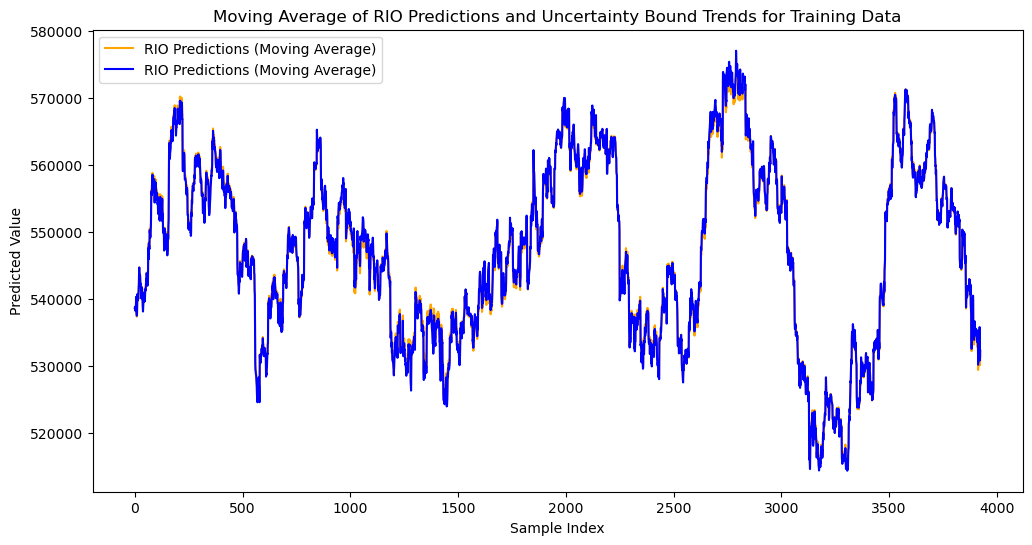

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def moving_average(data, window):
    return data.rolling(window=window).mean()

# Calculate the moving average values
window_size_pred = 400
window_size_rio = 400
window_size_bounds = 300
y_test_pred_xgb_ma = moving_average(pd.Series(y_test_pred_xgb), window_size_pred)
y_test_pred_xgb_rio_ma = moving_average(pd.Series(y_test_pred_xgb_rio), window_size_rio)
lower_bound_ma = moving_average(pd.Series(lower_bound), window_size_bounds)
upper_bound_ma = moving_average(pd.Series(upper_bound), window_size_bounds)

# Remove NaN values from the moving averages
y_test_pred_xgb_ma = y_test_pred_xgb_ma.dropna()
y_test_pred_xgb_rio_ma = y_test_pred_xgb_rio_ma.dropna()
lower_bound_ma = lower_bound_ma.dropna()
upper_bound_ma = upper_bound_ma.dropna()

# Adjust the size of the moving average of the lower/upper bounds to match that of the RIO predictions
num_padding = len(y_test_pred_xgb_rio_ma) - len(lower_bound_ma)
if num_padding > 0:
    padding = pd.Series(np.nan, index=np.arange(num_padding))
    lower_bound_ma = pd.concat([padding, lower_bound_ma])
    upper_bound_ma = pd.concat([padding, upper_bound_ma])
elif num_padding < 0:
    lower_bound_ma = lower_bound_ma.iloc[-num_padding:]
    upper_bound_ma = upper_bound_ma.iloc[-num_padding:]


# Generate the x-axis values
x_values = np.arange(len(y_test_pred_xgb_rio_ma))

# Create a plot of the RIO predictions and uncertainty boundaries
plt.figure(figsize=(12, 6))
plt.plot(x_values, y_test_pred_xgb_ma, label="RIO Predictions (Moving Average)", color='orange')
plt.plot(x_values, y_test_pred_xgb_rio_ma, label="RIO Predictions (Moving Average)", color='blue')

# Plot the trend of the lower and upper bounds
#plt.plot(x_values, lower_bound_ma, '-', color='red', alpha=0.5, label="Lower Bound Trend (Moving Average)")
#plt.plot(x_values, upper_bound_ma, '-', color='green', alpha=0.5, label="Upper Bound Trend (Moving Average)")

# Invert the lower bound line by subtracting it from the maximum value of the RIO predictions
#inverted_lower_bound_ma = y_pred_rio_ma.max() - lower_bound_ma
#plt.plot(x_values, inverted_lower_bound_ma, '-', color='red', alpha=0.5, label="Risk Band")

# Customize the plot
plt.xlabel("Sample Index")
plt.ylabel("Predicted Value")
plt.title("Moving Average of RIO Predictions and Uncertainty Bound Trends for Training Data")
plt.legend(loc='upper left')

# Show the plot
plt.show()
